# Exploratory Data Analysis

This notebook is for doing data checks and quick visualizations. 

In [12]:
# standard import
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

# advanced analytics
import statsmodels.api as sm

# establish database connections
conn = duckdb.connect("../data/lake/database.duckdb")

## Overview

Load tables and show distribution.

In [2]:
# climate_atmosphere data
climate_df = conn.sql("""
    SELECT
        date,
        adm3_en,
        adm3_pcode,
        adm4_en,
        adm4_pcode,
        tave,
        pr
    FROM public.project_cchain_climate_atmosphere_clean
    WHERE date >= '2020-01-01' AND date < '2022-12-31'
    ORDER BY date
    """).fetchdf()

climate_df = climate_df.drop_duplicates().reset_index()
climate_df["date"] = pd.to_datetime(climate_df["date"])
climate_df = climate_df.set_index("date")

daily_avg_df = (
    climate_df.groupby("adm3_pcode")
    .resample("D")
    .agg(
        {
            "adm3_en": "first",
            "adm4_pcode": "first",
            "tave": "mean",
            "pr": "mean",  # average per day
        }
    )
    .reset_index()
)

climate_df = (
    daily_avg_df.groupby("adm3_pcode")
    .resample("W-Mon", on="date")
    .agg(
        {
            "adm3_en": "first",
            "tave": "mean",
            "pr": "sum",  # sum per week
        }
    )
    .reset_index()
)

climate_df = climate_df[climate_df["date"] != "2023-01-02"]

climate_df

,adm3_pcode,date,adm3_en,tave,pr
0,PH015518000,2020-01-06,Dagupan City,26.772364,0.000000
1,PH015518000,2020-01-13,Dagupan City,26.612350,0.000000
2,PH015518000,2020-01-20,Dagupan City,26.675714,0.000000
3,PH015518000,2020-01-27,Dagupan City,26.099077,0.000000
4,PH015518000,2020-02-03,Dagupan City,25.076405,0.000000
...,...,...,...,...,...
1878,PH137603000,2022-11-28,City of Muntinlupa,28.404760,0.000000
1879,PH137603000,2022-12-05,City of Muntinlupa,28.331430,63.146667
1880,PH137603000,2022-12-12,City of Muntinlupa,27.578571,74.940002
1881,PH137603000,2022-12-19,City of Muntinlupa,27.482698,70.863335


In [3]:
# dengue data
dengue_df = conn.sql("""
    SELECT
        date,
        adm3_en,
        adm3_pcode,
        disease_common_name,
        case_total
    FROM public.project_cchain_disease_pidsr_totals_clean
    WHERE date >= '2020-01-01' AND date < '2022-12-31'
    """).fetchdf()

dengue_df = dengue_df.drop_duplicates().reset_index(drop=True)
dengue_df["date"] = pd.to_datetime(dengue_df["date"])
dengue_df = dengue_df.pivot(
    index=["date", "adm3_en", "adm3_pcode"],
    columns="disease_common_name",
    values="case_total",
).reset_index()

dengue_df = dengue_df.rename(
    columns={
        "ACUTE BLOODY DIARRHEA": "diarrhea_cases",
        "CHIKUNGUYA VIRAL DISEASE": "chikungunya_cases",
        "CHOLERA": "cholera_cases",
        "DENGUE FEVER": "dengue_cases",
        "HEPATITIS A": "hepa_a_cases",
        "LEPTOSPIROSIS": "lepto_cases",
        "RABIES": "rabies_cases",
        "ROTAVIRAL ENTERITIS": "rotavirus_cases",
        "TYPHOID FEVER": "typhoid_cases",
    }
)

dengue_df

disease_common_name,date,adm3_en,adm3_pcode,diarrhea_cases,chikungunya_cases,cholera_cases,dengue_cases,hepa_a_cases,lepto_cases,rabies_cases,rotavirus_cases,typhoid_cases
0,2020-01-06,Cagayan de Oro City,PH104305000,1,0,0,61,0,0,0,0,1
1,2020-01-06,City of Mandaluyong,PH137401000,0,0,0,58,0,0,0,0,0
2,2020-01-06,City of Muntinlupa,PH137603000,0,0,0,37,0,0,0,0,0
3,2020-01-06,City of Navotas,PH137503000,0,0,0,33,0,0,0,0,0
4,2020-01-06,Dagupan City,PH015518000,0,0,0,11,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1867,2022-12-26,Legazpi City,PH050506000,0,0,0,1,0,0,0,0,0
1868,2022-12-26,Mandaue City,PH072230000,0,0,0,4,0,0,0,0,0
1869,2022-12-26,Palayan City,PH034919000,0,0,0,0,0,0,0,0,0
1870,2022-12-26,Tacloban City,PH083747000,0,0,7,5,0,0,0,5,0


In [22]:
# merged_df
merged_df = pd.merge(
    climate_df, dengue_df, on=["date", "adm3_en", "adm3_pcode"], how="left"
)
merged_df.set_index("date", inplace=True)
merged_df

,adm3_pcode,adm3_en,tave,pr,diarrhea_cases,chikungunya_cases,cholera_cases,dengue_cases,hepa_a_cases,lepto_cases,rabies_cases,rotavirus_cases,typhoid_cases
date,,,,,,,,,,,,,
2020-01-06,PH015518000,Dagupan City,26.772364,0.000000,0,0,0,11,0,0,0,0,1
2020-01-13,PH015518000,Dagupan City,26.612350,0.000000,0,0,0,2,1,0,0,0,0
2020-01-20,PH015518000,Dagupan City,26.675714,0.000000,0,0,0,11,0,1,0,0,0
2020-01-27,PH015518000,Dagupan City,26.099077,0.000000,0,0,0,6,0,0,0,0,0
2020-02-03,PH015518000,Dagupan City,25.076405,0.000000,0,0,0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,PH137603000,City of Muntinlupa,28.404760,0.000000,0,0,0,28,0,0,0,0,0
2022-12-05,PH137603000,City of Muntinlupa,28.331430,63.146667,0,0,0,22,0,0,0,0,0
2022-12-12,PH137603000,City of Muntinlupa,27.578571,74.940002,0,0,0,15,0,0,0,0,0


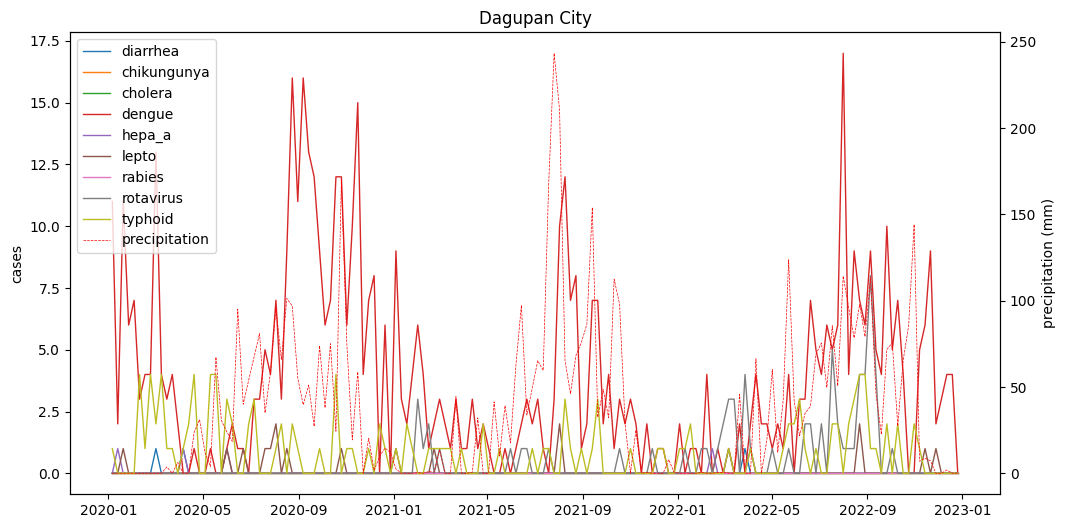

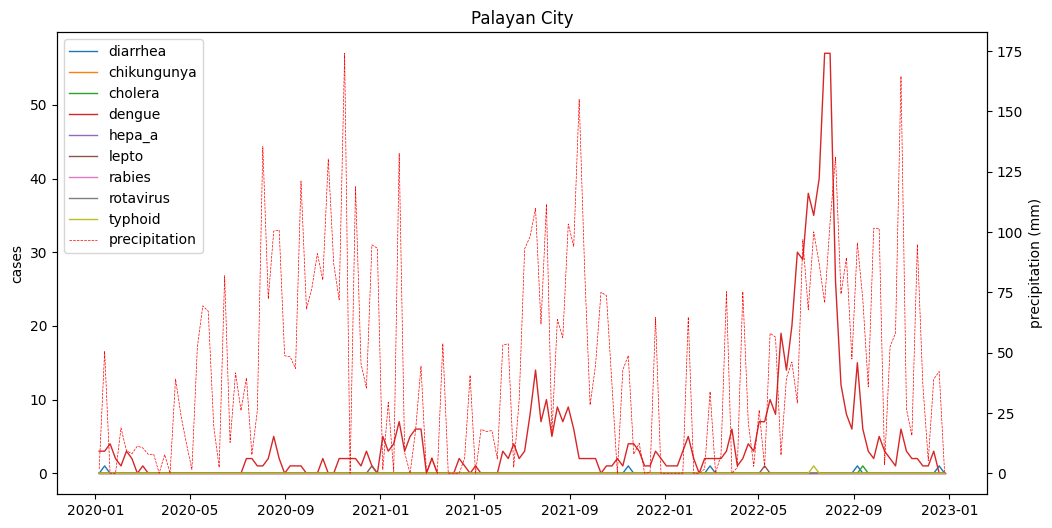

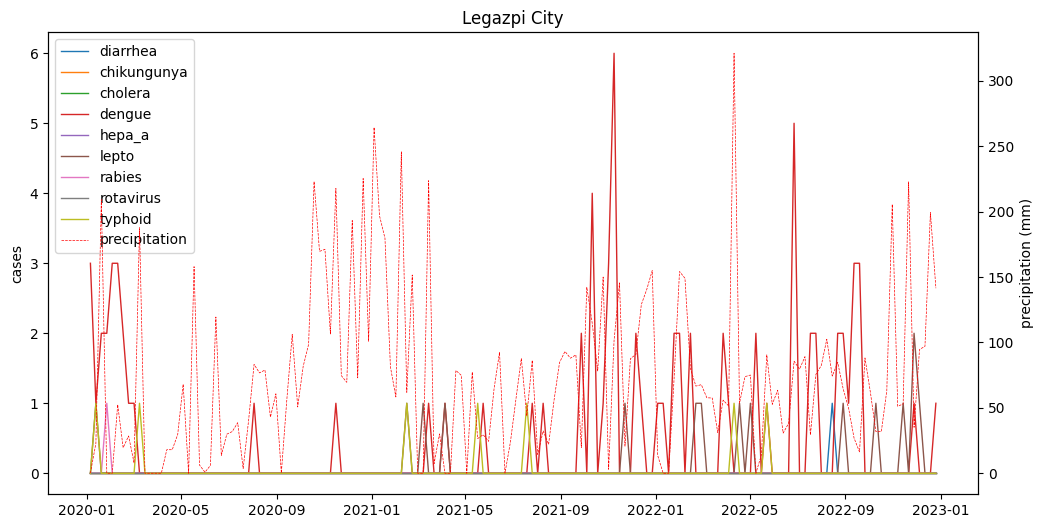

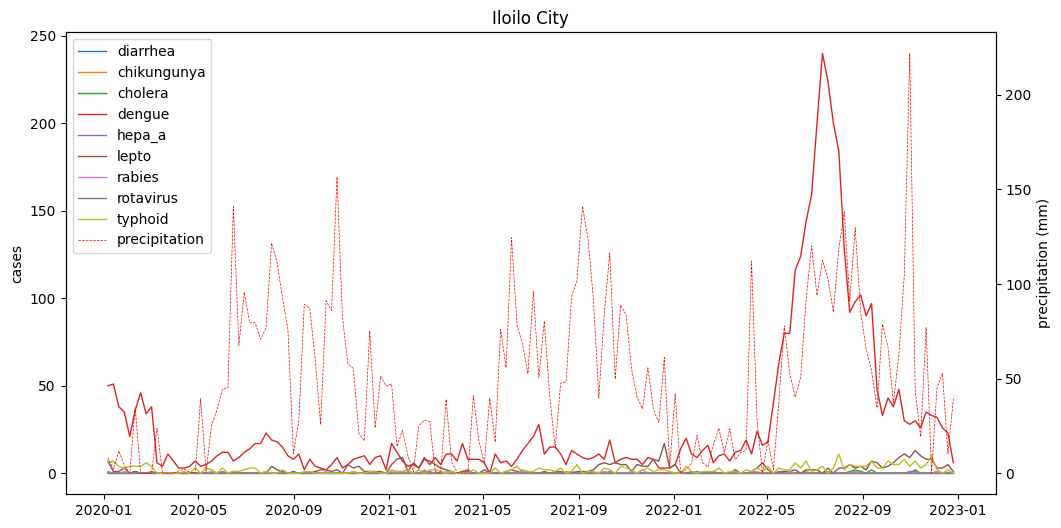

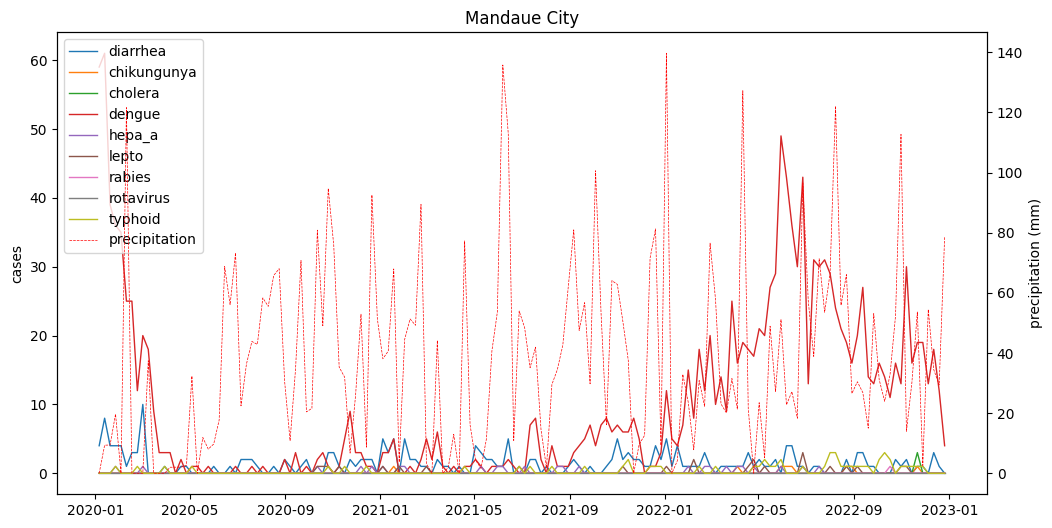

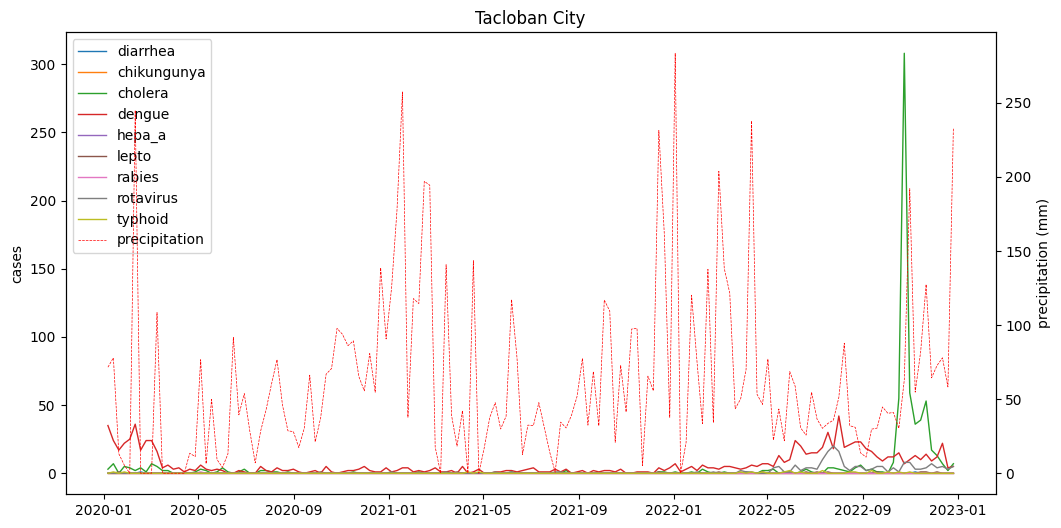

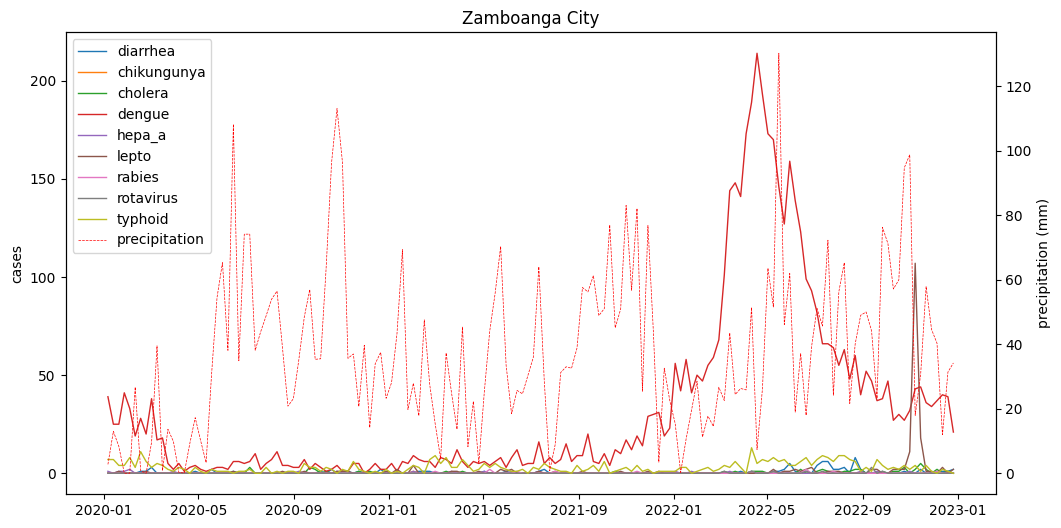

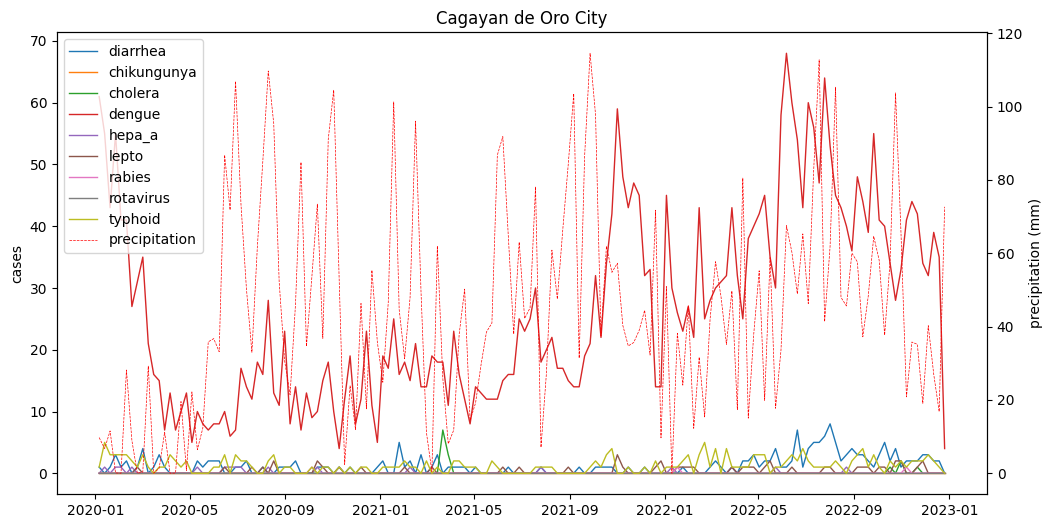

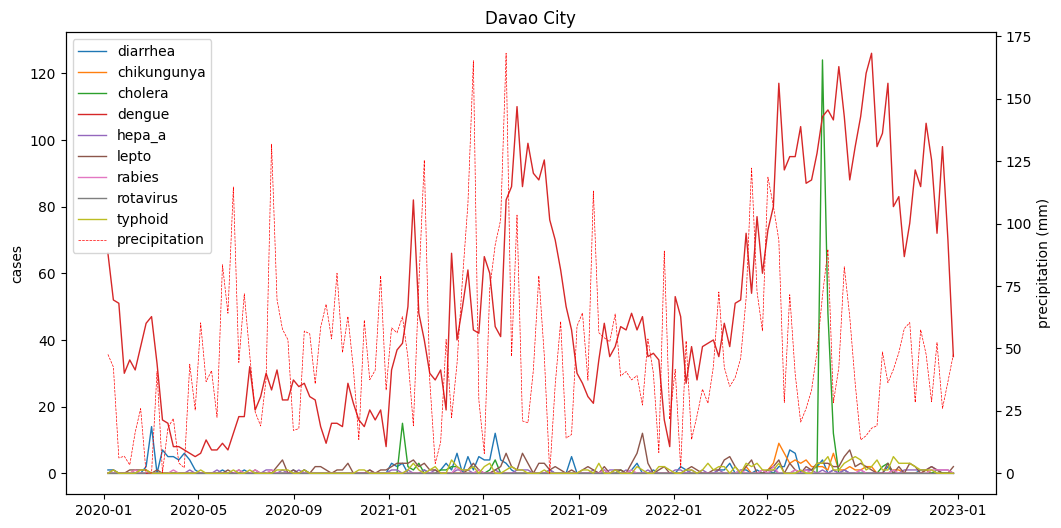

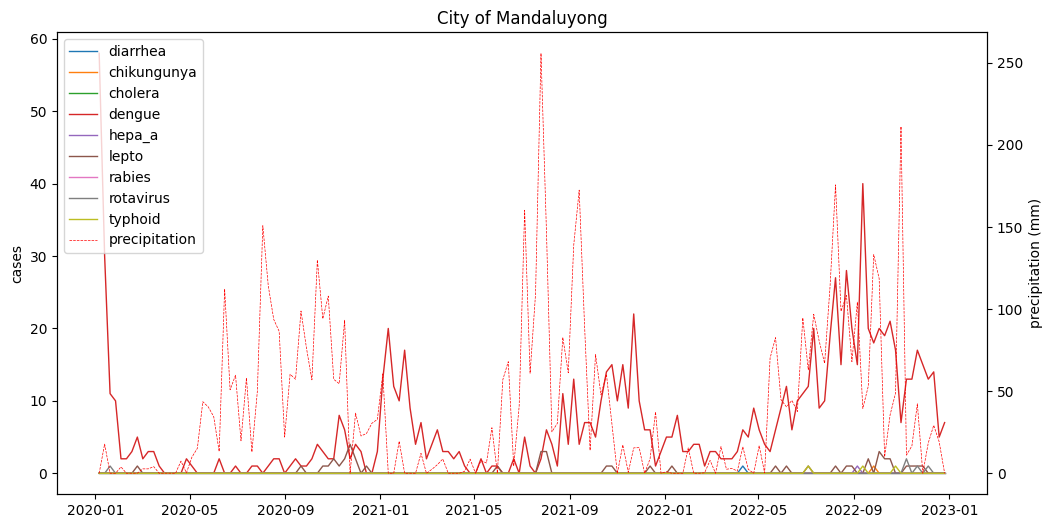

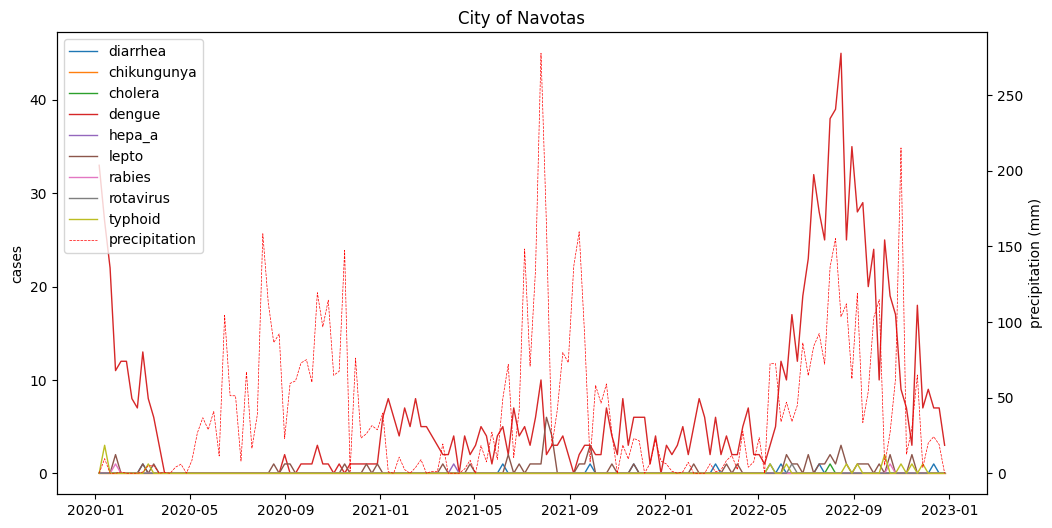

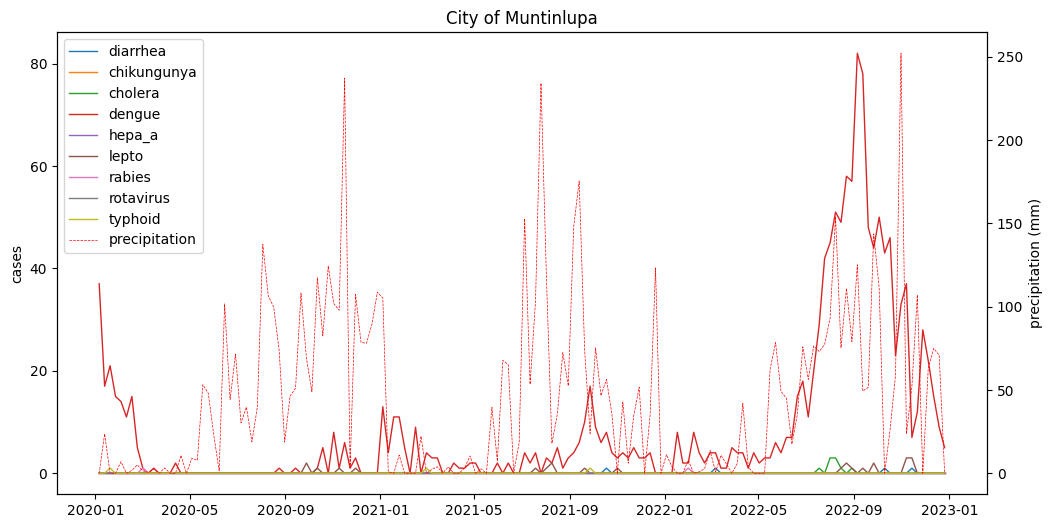

In [36]:
# List of diseases and cities (adm3_en)
disease_names = [
    "diarrhea_cases",
    "chikungunya_cases",
    "cholera_cases",
    "dengue_cases",
    "hepa_a_cases",
    "lepto_cases",
    "rabies_cases",
    "rotavirus_cases",
    "typhoid_cases",
]

adm3_en_list = merged_df["adm3_en"].unique()

# loop through adm3_en
for adm3 in adm3_en_list:
    adm3_data = merged_df[merged_df["adm3_en"] == adm3]

    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    for disease in disease_names:
        if disease in adm3_data.columns:
            disease_decomposition = sm.tsa.seasonal_decompose(
                adm3_data[disease], model="additive"
            )
            ax1.plot(
                disease_decomposition.observed.index,
                disease_decomposition.observed,
                label=disease.replace("_cases", ""),
                linewidth=1,
            )

    ax2.plot(
        adm3_data.index,
        adm3_data["pr"],
        color="red",
        label="precipitation",
        linewidth=0.5,
        linestyle="--",
    )

    ax1.set_title(f"{adm3}")
    # ax1.set_xlabel('date')
    ax1.set_ylabel("cases")
    ax2.set_ylabel("precipitation (mm)")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    # ax1.grid()
    plt.show()